In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, Model
from keras.optimizers import rmsprop
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D,  MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, Input, Lambda 
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.backend import tf as ktf

# from keras.preprocessing.image import 

from sklearn.model_selection import train_test_split

import cv2

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def load(train_fn: str, test_fn: str, n_lines_train, n_lines_test):
    
    def read_csv(file_name, n_lines, label=True):
        x = np.ndarray(shape=(n_lines, 3072))
        y = []
        with open(file_name, 'r') as f_in:
            f_in.readline()
            for i in range(n_lines):
                line = f_in.readline().split('"')
                x[i] = [int(pix) for pix in line[1].split(',')]
                if label:
                    l_name = line[2].strip(',').strip()
                    y.append(LABELS.index(l_name))
        return x, y
    
    x_train, y_train = read_csv(train_fn, n_lines_train)
    x_test, _ = read_csv(test_fn, n_lines_test, label=False)    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
    
    return (x_train, y_train, x_val, y_val), x_test


def predict(clf,
            X_test: np.array,
            output_fn: str):
    y_pred = clf.predict_classes(X_test)
    y_pred = [LABELS[pred] for pred in y_pred]
    test_df = pd.DataFrame(data={'Category': y_pred})
    test_df.to_csv(output_fn, index_label='Id')
    return y_pred

In [3]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx].reshape(32, 32, 3)
        image = image.astype(np.uint8)
        plt.imshow(image)
        plt.title(LABELS[labels[idx]] if labels is not None else '?')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [4]:
def show_random_images_by_class(x, labels, l_text, n_classes, img_per_class=10):
    inch_per_pic = 1
    fig, plots = plt.subplots(n_classes, img_per_class)
    fig.set_size_inches(inch_per_pic * img_per_class, inch_per_pic * n_classes)

    for cls in range(n_classes):
        imgs = x[np.argwhere(labels == cls)[:, 0].flatten()]
        imgs = imgs[np.random.choice(imgs.shape[0], size=img_per_class, replace=False)]
        plots[cls, 0].set_ylabel(l_text[cls], va='center', ha='right',rotation=0, size=15)
        for i in range(img_per_class):
            plots[cls, i].imshow(imgs[i], cmap='gray')
            plots[cls, i].set_xticks([])
            plots[cls, i].set_yticks([])
    fig.tight_layout()

In [5]:
def show_most_confident_predictions(ds, model, h=5, w=5, reverse=False):
    n_img = min(h * w, ds.shape[0])
    
    preds = model.predict(ds, verbose=0)
    if reverse:
        extreame_conf = np.argsort(np.max(preds, axis=1))[:n_img]
    else:
        extreame_conf = np.argsort(np.max(preds, axis=1))[-n_img::-1]
    x = ds[extreame_conf]
    preds = [preds[i] for i in extreame_conf]
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i in range(n_img):
        plt.subplot(h, w, i + 1)
        image = x[i].reshape(image_height, image_width, n_channels)
        plt.imshow(image)
        title = '%s\n%0.2f%%' % (LABELS[np.argmax(preds[i])], 100 * np.max(preds[i]))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [6]:
def predict_random_images(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    labels = model.predict(subset, verbose=0)
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))    
    for i, label in enumerate(labels):
        print(label)
        plt.subplot(h, w, i + 1)
        image = subset[i].reshape(32, 32, 3)
#         image = image.astype(np.uint8)
        plt.imshow(image/255)
        plt.title(LABELS[np.argmax(label)])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [7]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [8]:
n_channels = 3
LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
n_classes = len(LABELS)

In [45]:
n_lines_train = 30000
n_lines_test = 10000
(x_train, y_train, x_val, y_val), x_test = load('train.csv', 'test.csv', n_lines_train, n_lines_test)

In [46]:
print(x_train.shape, len(y_train)) 
print(x_val.shape, len(y_val))
print(x_test.shape)

(24000, 3072) 24000
(6000, 3072) 6000
(10000, 3072)


In [47]:
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
x_train = x_train[:,:,:,::-1]
x_val = x_val[:,:,:,::-1]
x_test = x_test[:,:,:,::-1]

In [48]:
print(x_train.shape, len(y_train)) 
print(x_val.shape, len(y_val))
print(x_test.shape)

(24000, 32, 32, 3) 24000
(6000, 32, 32, 3) 6000
(10000, 32, 32, 3)


TRAIN


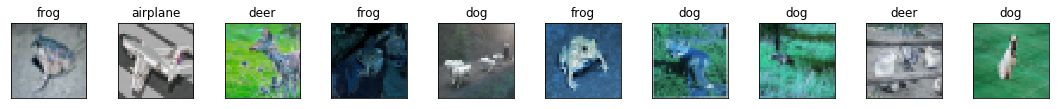

VAL


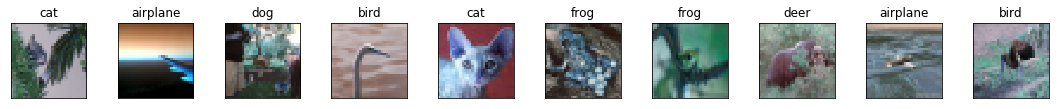

TEST


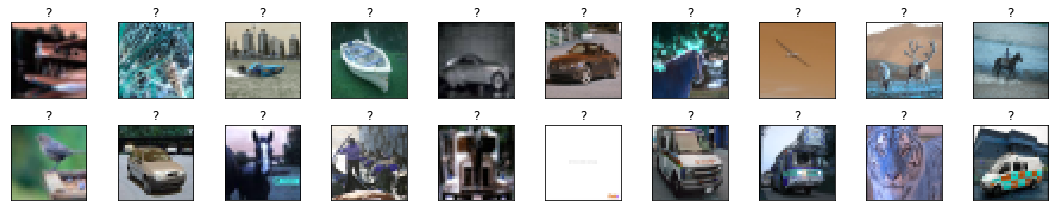

In [49]:
print('TRAIN')
show_random_images(x_train, y_train, 1, 10)
print('VAL')
show_random_images(x_val, y_val, 1, 10)
print('TEST')
show_random_images(x_test, None, 2, 10)

In [50]:
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

In [51]:
# x_train = x_train / 255.
# x_val = x_val / 255.
# x_test = x_test / 255.

In [52]:
def lr_scheduler(epoch):
    lr = 1e-4
    if epoch > 30:
        lr = 5e-5
    if epoch > 50:
        lr = 3e-5
    if epoch > 75:
        lr = 1e-5
#     if epoch > 100:
#         lr = 3e-4
#     if epoch > 100:
#         lr = 3e-4
#     if epoch > 100:
#         lr = 3e-4
#     if epoch > 100:
#         lr = 3e-4
    return lr
#  From cinic cnn
# def lr_scheduler(epoch):
#     lr = 1e-3
#     if epoch > 50:
#         lr = 5e-4
#     if epoch > 100:
#         lr = 3e-4
#     if epoch > 150:
#         lr = 2e-4
#     if epoch > 200:
#         lr = 1e-4
#     if epoch > 250:
#         lr = 5e-5
#     return lr

In [53]:
def build_model():
    
    inputs = Input(shape=(32, 32, 3))
    inputs = Lambda(lambda image: preprocess_input(ktf.image.resize_images(image, (150, 150))))(inputs)
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable = False      
    
    x = base_model.output

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.4)(x)
#  BGR cinic-10 val acc = 55% (only head)
#     x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
#     x = Dropout(0.3)(x)

#     x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
#     x = Dropout(0.3)(x)
    
#     x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
#     x = Dropout(0.2)(x)

    #  cifar-10 val acc = 85% (head -> head + backbone ([249:], last inception block))
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(n_classes, activation='softmax')(x)
    
    model = Model(base_model.inputs, x)
    
    opt = rmsprop(lr=1e-4)  # mb 1e-3?
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [54]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation

In [55]:
l_sch = LearningRateScheduler(lr_scheduler)
check = ModelCheckpoint('models/model_epoch_{epoch:02d}_val_acc_{val_acc:.5f}.hdf5',
                         monitor='val_acc',
                         mode='max',
                         save_best_only=True)
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

In [56]:
img_aug_gen = ImageDataGenerator(rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True, 
                                 zoom_range=0.3)

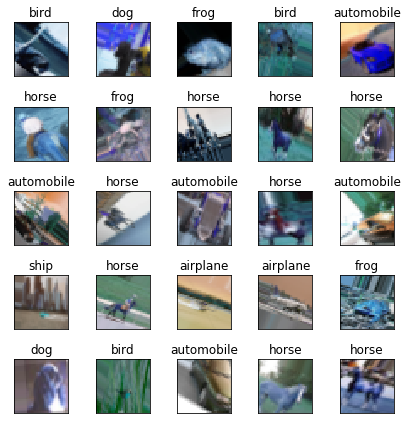

In [57]:
x_batch, y_batch = next(img_aug_gen.flow(x_train, y_train, batch_size=25))

plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_batch[i].reshape(32,32,3)/255.)
    plt.title(LABELS[np.argmax(y_batch[i])])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [58]:
history = model.fit_generator(img_aug_gen.flow(x_train, y_train, batch_size=16),
                              steps_per_epoch=x_train.shape[0] // 16,
                              validation_data=(x_val, y_val),
                              callbacks=[tb, l_sch], 
                              epochs=100)

Epoch 1/100
1500/1500 [==============================] - 30s 20ms/step - loss: 2.3902 - acc: 0.1611 - val_loss: 1.9262 - val_acc: 0.3127
Epoch 2/100
1500/1500 [==============================] - 28s 19ms/step - loss: 2.1756 - acc: 0.2477 - val_loss: 1.6920 - val_acc: 0.4148
Epoch 3/100
1500/1500 [==============================] - 27s 18ms/step - loss: 2.0902 - acc: 0.2760 - val_loss: 1.6339 - val_acc: 0.4527
Epoch 4/100
1500/1500 [==============================] - 25s 17ms/step - loss: 2.0440 - acc: 0.2971 - val_loss: 1.6108 - val_acc: 0.4560
Epoch 5/100
1500/1500 [==============================] - 26s 17ms/step - loss: 2.0233 - acc: 0.3020 - val_loss: 1.5708 - val_acc: 0.4808
Epoch 6/100
1500/1500 [==============================] - 26s 17ms/step - loss: 1.9971 - acc: 0.3139 - val_loss: 1.6959 - val_acc: 0.4752
Epoch 7/100
1500/1500 [==============================] - 26s 17ms/step - loss: 1.9768 - acc: 0.3233 - val_loss: 1.7870 - val_acc: 0.4583
Epoch 8/100
1500/1500 [==================

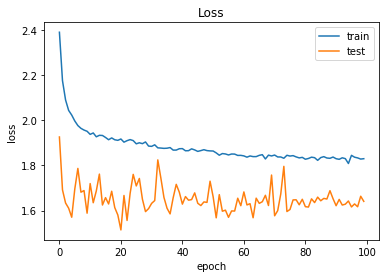

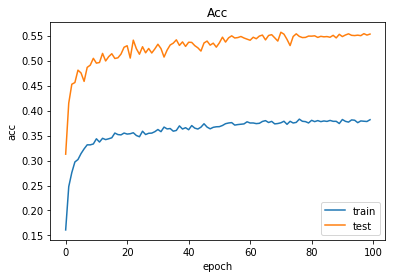

In [59]:
plot_history(history)

In [60]:
acc = model.evaluate(x_train, y_train, verbose=0)[1]
print('Model train acc: %0.2f%%' % (100 * acc))

val_acc = model.evaluate(x_val, y_val, verbose=0)[1]
print('Model val acc: %0.2f%%' % (100 * val_acc))

Model train acc: 55.99%
Model val acc: 55.30%


[1.8417618e-06 1.4969249e-06 7.0350957e-03 8.0151986e-03 3.8865125e-03
 8.4415468e-04 9.8017615e-01 3.1362921e-05 7.4752802e-06 7.9683861e-07]
[0.03155856 0.24102522 0.02189914 0.02262354 0.04308006 0.03184921
 0.01640483 0.10754277 0.07007043 0.41394624]
[9.1874534e-01 2.4318601e-06 9.4839628e-04 3.0852596e-07 1.2930414e-04
 3.1758477e-06 1.5707134e-07 1.8581539e-05 8.0150090e-02 2.2146733e-06]
[8.0216005e-02 1.8424755e-01 1.3548649e-03 5.4146186e-03 6.8210461e-03
 1.3831568e-02 1.2148191e-04 4.3929137e-02 4.2493124e-02 6.2157053e-01]
[7.9032546e-01 3.8228851e-02 9.5910364e-04 1.9249217e-04 3.5837307e-04
 1.9725792e-03 1.0090932e-06 1.4498658e-03 1.5304480e-01 1.3467359e-02]
[0.27336383 0.02866342 0.03188932 0.02220835 0.08069714 0.04745137
 0.00293936 0.1442298  0.31230536 0.05625197]
[2.6045641e-16 2.2165589e-11 2.1107350e-11 1.7625740e-06 3.7257416e-11
 9.9999821e-01 4.6759395e-13 1.4015832e-08 2.9602107e-15 4.5787170e-13]
[8.3071248e-16 2.7628279e-05 6.8147515e-22 3.8069744e-19 1.

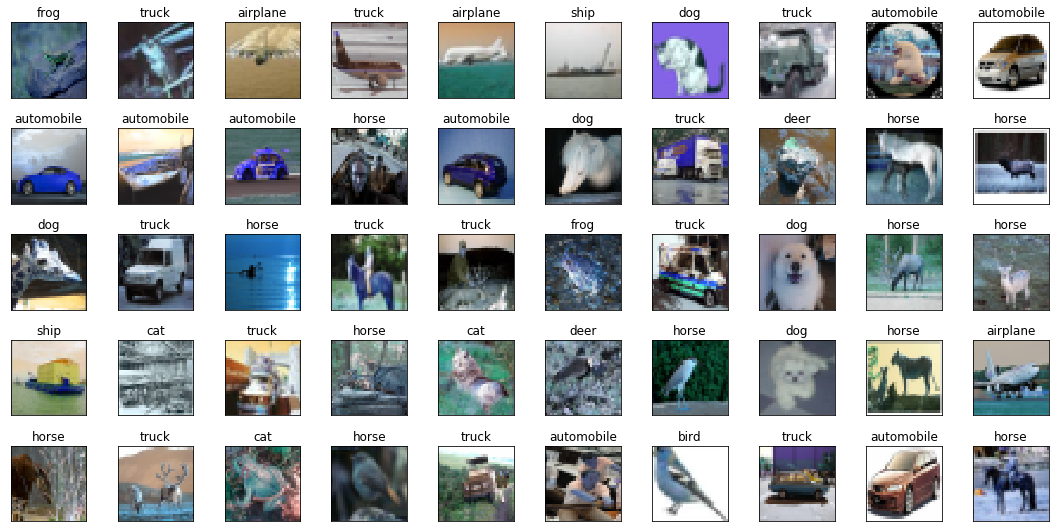

In [61]:
predict_random_images(x_test, model, 5, 10)

In [26]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [28]:
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)
opt = rmsprop(lr=1e-4)  # , decay=1e-4/100)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_1 = model.fit_generator(img_aug_gen.flow(x_train, y_train, batch_size=32),
                              steps_per_epoch=x_train.shape[0] // 32,
                              validation_data=(x_val, y_val),
                              callbacks=[tb], 
                              epochs=100)

Epoch 1/100
1562/1562 [==============================] - 52s 33ms/step - loss: 1.1675 - acc: 0.6103 - val_loss: 1.6075 - val_acc: 0.7502
Epoch 2/100
1562/1562 [==============================] - 47s 30ms/step - loss: 0.9913 - acc: 0.6714 - val_loss: 1.2462 - val_acc: 0.7836
Epoch 3/100
1562/1562 [==============================] - 48s 31ms/step - loss: 0.9076 - acc: 0.6985 - val_loss: 1.1880 - val_acc: 0.7970
Epoch 4/100
1562/1562 [==============================] - 47s 30ms/step - loss: 0.8633 - acc: 0.7188 - val_loss: 1.1021 - val_acc: 0.8001
Epoch 5/100
1562/1562 [==============================] - 48s 31ms/step - loss: 0.8234 - acc: 0.7289 - val_loss: 1.4714 - val_acc: 0.7536
Epoch 6/100
1562/1562 [==============================] - 48s 31ms/step - loss: 0.8016 - acc: 0.7363 - val_loss: 1.2550 - val_acc: 0.7806
Epoch 7/100
1562/1562 [==============================] - 48s 31ms/step - loss: 0.7731 - acc: 0.7474 - val_loss: 1.0195 - val_acc: 0.7962
Epoch 8/100
1562/1562 [==================

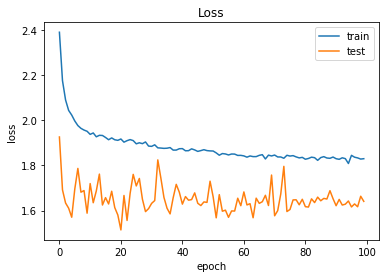

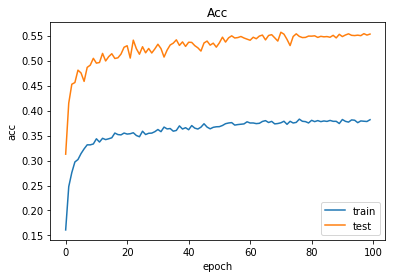

In [59]:
plot_history(history_1)

In [60]:
acc = model.evaluate(x_train, y_train, verbose=0)[1]
print('Model train acc: %0.2f%%' % (100 * acc))

val_acc = model.evaluate(x_val, y_val, verbose=0)[1]
print('Model val acc: %0.2f%%' % (100 * val_acc))

Model train acc: 55.99%
Model val acc: 55.30%


In [24]:
y_pred = predict(model, x_test, 'submissions/submission_3_%0.5f.csv' % val_acc)

In [ ]:
model.save('model_val_acc_%0.4f.hdf5' % val_acc)

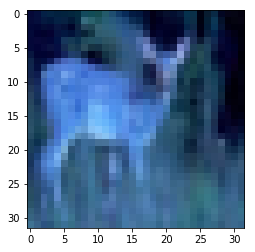

In [100]:
plt.imshow(x_test[1]/255.)

In [98]:
model_proc = Model(model.input, model.layers[1].output)

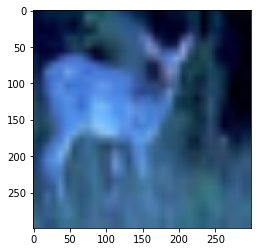

In [107]:
plt.imshow((model_proc.predict(np.expand_dims(x_test[1], axis=0))[0]+1)/2)